### Importing Libraries

In [20]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
import wandb
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA as PCA2

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline


### Defining random state, device and batch_size

In [21]:
random_seed = 42
np.random.seed(random_seed)

In [22]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device :',device)

import warnings
warnings.filterwarnings("ignore")


Device : cuda


In [23]:
batch_size = 100

### Loading the dataset

In [24]:
# definind transform for the MNIST dataset
# converting to tensors and normalize pixel vals with mean 0.5 and std-deviation 0.5
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Download and load the train set
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test set
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print("Training set size:", len(trainset))
print("Test set size:", len(testset))


Training set size: 60000
Test set size: 10000


In [25]:
# Accessing a batch of data
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)


Batch of images shape: torch.Size([100, 1, 28, 28])
Batch of labels shape: torch.Size([100])


# 1. Class for SIFT-SVM-BoVW

Functions in the class 

- `__init__` : Initializes the datasets and vocabulary size

- `getVocabulary` : Considers all train images and performs K-means on SIFT descriptors of the images to for k-clusters or k-sized vocabulary

- `prepareData` : Consider a dataset (eg. trainset) and converts all images into the histogram representation with respect to the vocabulary created

- `get_sift_feature` : Extracts and returns the SIFT descriptor for the input image

- `train` and `test` : Use pipelined LinearSVM for fast training on the trainset and perform fast inference on the testset and return the accuracy

In [14]:
class SIFT_SVM:
    def __init__(self, trainset, testset, vocabulary_size):
        self.trainset = trainset
        self.testset = testset
        self.vocabulary_size = vocabulary_size
        self.cluster_centers = self.getVocabulary(trainset,vocabulary_size)
        self.prepareData()
        
    # gets SIFT descriptor for a single image
    def get_sift_feature(self, image):
        image = image.numpy()
        gray = image.squeeze().astype(np.uint8)  # Convert to grayscale
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        return keypoints, descriptors
    
    # extracts sift features from the dataset and converts into BoVW vocabulary and returns it
    def getVocabulary(self, dataset,size_vocabulary):
        size_dataset = len(dataset)
        sift_features = []

        for i in range(size_dataset):
            image, label = dataset[i]
            keypoints, descriptors = self.get_sift_feature(image)
            if descriptors is not None:
                for descriptor in descriptors:
                    sift_features.append(descriptor)

        sift_features = np.array(sift_features)
        num_clusters = size_vocabulary
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(sift_features)
        cluster_centers = kmeans.cluster_centers_
        return cluster_centers
    
    def getFeatures(self,dataset):
        size_dataset = len(dataset)
        histograms = []
        images = []
        labels = []
        for i in range(size_dataset):
            # initializing histograms for each image
            histogram = np.zeros((self.vocabulary_size,1))
            image, label = dataset[i]
            keypoints, descriptors = self.get_sift_feature(image)
            if descriptors is not None:
                images.append(image.numpy())
                labels.append(label)
                for descriptor in descriptors:
                    descriptor = descriptor.reshape(1,-1) #reshaped tp (1,128)
                    distances = np.linalg.norm(self.cluster_centers - descriptor, axis=1)
                    min_distance_index = np.argmin(distances)
                    histogram[min_distance_index] = histogram[min_distance_index]+1
                histogram = np.array(histogram)
                histograms.append(histogram)

        histograms = np.array(histograms)
        histograms = histograms.reshape((histograms.shape[0],histograms.shape[1]))
        images = np.array(images)
        images = np.reshape(images, (images.shape[0], 28, 28, 1))
        labels = np.array(labels)
        return histograms,images,labels
    
    # to convert the dataset into featurespace and do PCA (optional)
    def prepareData(self,num_features=None):
        self.X_train, self.train_images, self.y_train = self.getFeatures(self.trainset)
        self.X_test, self.test_images, self.y_test = self.getFeatures(self.testset)
        if num_features is not None:
            self.X_train = self.reduceDimension(X_train, num_features)
            self.X_test = self.reduceDimension(X_test, num_features)
            
    # function to plot feature histograms for some of the images
    def plotHistograms(self, histograms, images, num_histograms):
        selected_indices = np.random.choice(len(histograms), size=num_histograms, replace=False)
        fig, axs = plt.subplots(num_histograms, 2, figsize=(10, 10))

        for i, idx in enumerate(selected_indices):
            axs[i, 0].imshow(images[idx], cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Image')
            axs[i, 1].bar(range(len(histograms[idx])), histograms[idx])
            axs[i, 1].set_title('Histogram')
        plt.tight_layout()
        plt.show()

    def train(self):
        self.svm_classifier_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual = 'auto'))
        self.svm_classifier_pipeline.fit(self.X_train,self.y_train)
    
    def test(self):
        predicted_labels = self.svm_classifier_pipeline.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predicted_labels)
        return accuracy


        

### Example run of the model

In [19]:
num_clusters = 100
model = SIFT_SVM(trainset,testset,num_clusters)
model.train()
acc = model.test()
print("Accuracy : ",acc)

Accuracy :  0.7542185616713539


In [20]:
acc = model.test()
print("Accuracy : ",acc)

Accuracy :  0.7542185616713539


### Plotting Features Histograms for few images

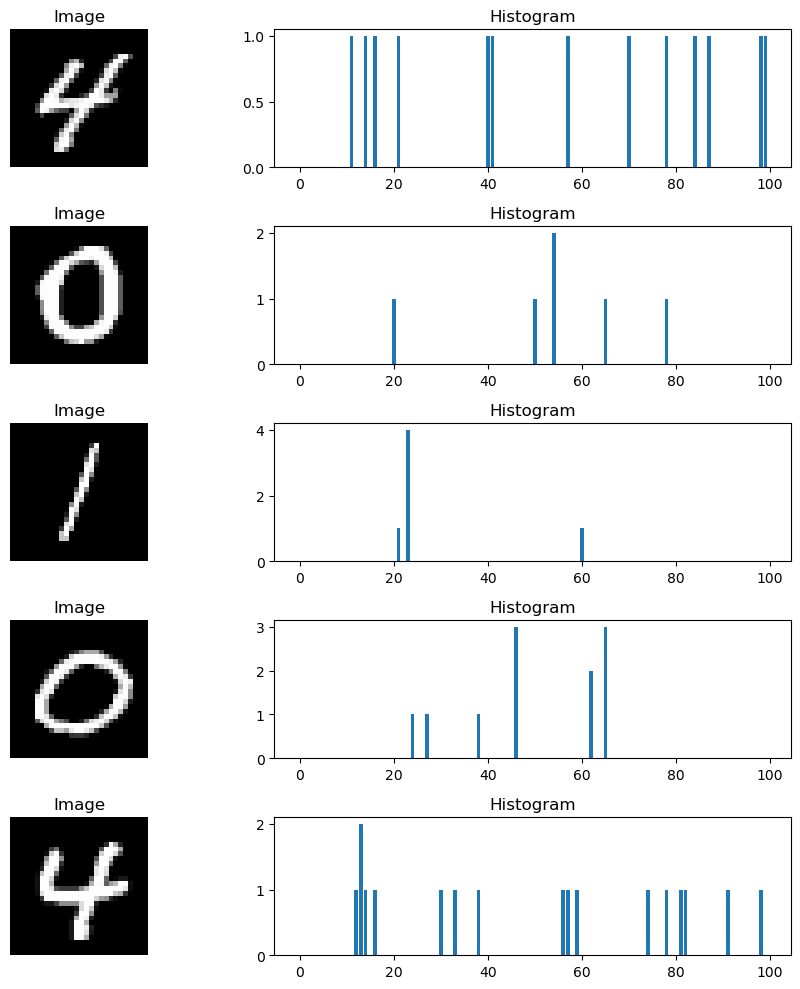

In [21]:
model.plotHistograms(model.X_train,model.train_images,5)

### Cluster Centers or Vocabulary

In [22]:
cluster_centers = model.cluster_centers
print("Cluster Centers : \n",cluster_centers)

Cluster Centers : 
 [[1.1132140e+01 3.0255709e+00 5.3984184e+00 ... 8.5940361e-03
  2.2185326e-02 5.9361076e-01]
 [1.6350899e+00 1.8524780e+00 1.7809780e+01 ... 1.6997337e-01
  6.8628311e-02 5.5081801e+00]
 [9.4494686e+00 2.0599522e+01 6.8960968e+01 ... 7.2164774e-02
  5.3535938e-02 1.3344736e+00]
 ...
 [8.0589361e+00 1.6764069e+01 4.2367977e+01 ... 1.2289524e-02
  5.7130337e-02 1.1775551e+00]
 [1.6458065e+01 2.2725355e+01 4.8776611e+01 ... 4.8895645e-01
  2.9821968e-01 1.4966249e+00]
 [1.9423542e+00 1.8798046e+01 5.5754303e+01 ... 4.4123540e+00
  5.1765728e+00 7.9762077e-01]]


# 2. Plotting how accuracy changes with numbe of clusters

In [23]:
num_clusters_values = [10,20,40,80,140,200]
accuracies = []

for num_clusters in num_clusters_values:
    model = SIFT_SVM(trainset,testset,num_clusters)
    model.train()
    acc = model.test()
    accuracies.append(acc)
    print("For ",num_clusters," clusters, Accuracy = ",acc)

For  10  clusters, Accuracy =  0.4255725190839695
For  20  clusters, Accuracy =  0.5210928083567697
For  40  clusters, Accuracy =  0.6458417034953796
For  80  clusters, Accuracy =  0.734933708316593
For  140  clusters, Accuracy =  0.7791281639212535
For  200  clusters, Accuracy =  0.8127762153475291


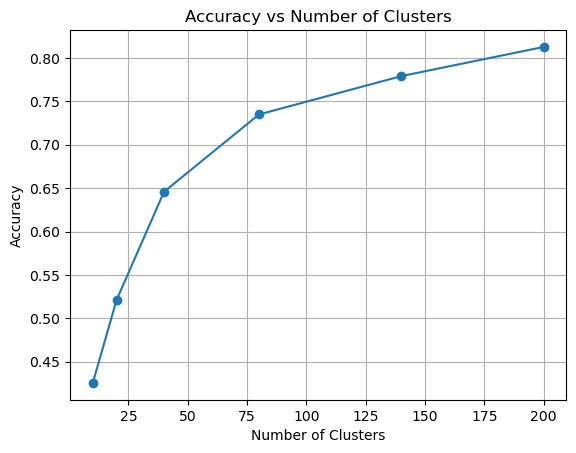

In [27]:
plt.plot(num_clusters_values, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Clusters')
plt.grid(True)
plt.show()


### Observations and explanation of trend

- We can clearly see that as we increase the number of clusters (i.e. the size of the vocabulary) the accuracy increases. Ofcourse this accuracy starts to saturate after large number of clusters. More the number of clusters, greater the size of the vocabulary for BoVW representation. Thus, each image can be represented more accurately by the BoVW histogram. 

- For example, if we keep the number of clusters to 10, it simply means that we need to represent each image using a histogram having 10 bins. Since each image must be displayed differently, this directly means that each cluster center is alloted to exactly one label. Thus, it is the simple case of just K-means clustering.

- However, if we increase the number of clusters, the feature space also increases. Therefore, we have more freedom to represent our images as a combination of the individual words of the vocabulary and thus images have better representation in the feature space, directly relating to better dataset for the SVM and better results in terms of accuracy. 

# 3. Trends in Hyperparameters

In [26]:
# class with hyperparameter tuning available and wandb logging
class My_SIFT_SVM:
    def __init__(self, trainset, testset, vocabulary_size,regularization_parameter, max_iter):
        self.trainset = trainset
        self.testset = testset
        self.vocabulary_size = vocabulary_size
        self.cluster_centers = self.getVocabulary(trainset,vocabulary_size)
        self.prepareData()
        self.C = regularization_parameter
        self.max_iter = max_iter
        
        
        # configuring and initializing wandb for logging the run
        config = {"regularization_parameter": self.C, "max_iter": self.max_iter}
        wandb.init(project="SIFT-SVM-MoVW-3",config=config)  # Initialize wandb

        
    # gets SIFT descriptor for a single image
    def get_sift_feature(self, image):
        image = image.numpy()
        gray = image.squeeze().astype(np.uint8)  # Convert to grayscale
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        return keypoints, descriptors
    
    # extracts sift features from the dataset and converts into BoVW vocabulary and returns it
    def getVocabulary(self, dataset,size_vocabulary):
        size_dataset = len(dataset)
        sift_features = []

        for i in range(size_dataset):
            image, label = dataset[i]
            keypoints, descriptors = self.get_sift_feature(image)
            if descriptors is not None:
                for descriptor in descriptors:
                    sift_features.append(descriptor)

        sift_features = np.array(sift_features)
        num_clusters = size_vocabulary
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(sift_features)
        cluster_centers = kmeans.cluster_centers_
        return cluster_centers
    
    def getFeatures(self,dataset):
        size_dataset = len(dataset)
        histograms = []
        images = []
        labels = []
        for i in range(size_dataset):
            # initializing histograms for each image
            histogram = np.zeros((self.vocabulary_size,1))
            image, label = dataset[i]
            keypoints, descriptors = self.get_sift_feature(image)
            if descriptors is not None:
                images.append(image.numpy())
                labels.append(label)
                for descriptor in descriptors:
                    descriptor = descriptor.reshape(1,-1) #reshaped tp (1,128)
                    distances = np.linalg.norm(self.cluster_centers - descriptor, axis=1)
                    min_distance_index = np.argmin(distances)
                    histogram[min_distance_index] = histogram[min_distance_index]+1
                histogram = np.array(histogram)
                histograms.append(histogram)

        histograms = np.array(histograms)
        histograms = histograms.reshape((histograms.shape[0],histograms.shape[1]))
        images = np.array(images)
        images = np.reshape(images, (images.shape[0], 28, 28, 1))
        labels = np.array(labels)
        return histograms,images,labels
    
    # to convert the dataset into featurespace and do PCA (optional)
    def prepareData(self,num_features=None):
        self.X_train, self.train_images, self.y_train = self.getFeatures(self.trainset)
        self.X_test, self.test_images, self.y_test = self.getFeatures(self.testset)
        if num_features is not None:
            self.X_train = self.reduceDimension(X_train, num_features)
            self.X_test = self.reduceDimension(X_test, num_features)
            
    # function to plot feature histograms for some of the images
    def plotHistograms(self, histograms, images, num_histograms):
        selected_indices = np.random.choice(len(histograms), size=num_histograms, replace=False)
        fig, axs = plt.subplots(num_histograms, 2, figsize=(10, 10))

        for i, idx in enumerate(selected_indices):
            axs[i, 0].imshow(images[idx], cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Image')
            axs[i, 1].bar(range(len(histograms[idx])), histograms[idx])
            axs[i, 1].set_title('Histogram')
        plt.tight_layout()
        plt.show()

    def train(self):
        self.svm_classifier_pipeline = make_pipeline(StandardScaler(), LinearSVC(dual = 'auto', C=self.C, max_iter=self.max_iter))
        self.svm_classifier_pipeline.fit(self.X_train,self.y_train)
    
    def test(self):
        predicted_labels = self.svm_classifier_pipeline.predict(self.X_test)
        self.accuracy = accuracy_score(self.y_test, predicted_labels)
        wandb.log({"Accuracy": self.accuracy})  # Log accuracy
        return self.accuracy


        

### Keeping the number of clusters = 200 (best performance from previous part)

Hyperparameters tuned are :
1. `regularization_parameter` (C) : Decides the tradeoff between maximizing margin and minimizing training error. Values used are [0.001, 0.01] 
2. `max_iteration` : The maximum number of iterations to be run. Values used are  [1000, 2000, 3000]


In [27]:
C_vals = [0.001,0.01]
max_iter_vals = [1000, 2000, 3000]
num_clusters = 200

for C in C_vals:
    for max_iter in max_iter_vals:
        model = My_SIFT_SVM(trainset,testset,num_clusters,C,max_iter)
        model.train()
        acc = model.test()
        print("C = ",C," and max_iterations = ",max_iter," Accuracy : ",acc)

wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


C =  0.001  and max_iterations =  1000  Accuracy :  0.8024306950582564


Accuracy,▁
Accuracy,0.80243


C =  0.001  and max_iterations =  2000  Accuracy :  0.799517878666131


Accuracy,▁
Accuracy,0.79952


C =  0.001  and max_iterations =  3000  Accuracy :  0.7949979911611089


Accuracy,▁
Accuracy,0.795


C =  0.01  and max_iterations =  1000  Accuracy :  0.8036359983929289


Accuracy,▁
Accuracy,0.80364


C =  0.01  and max_iterations =  2000  Accuracy :  0.8012253917235838


Accuracy,▁
Accuracy,0.80123


C =  0.01  and max_iterations =  3000  Accuracy :  0.8065488147850542


## Observations and trends in Accuracy

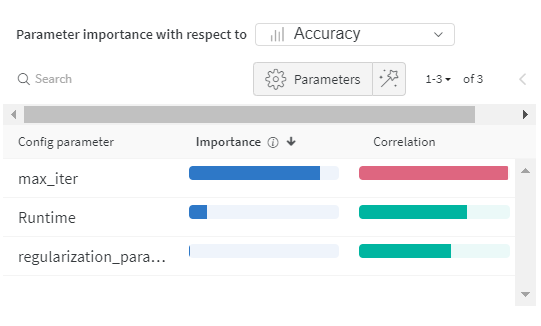
Observing from the logged parameter importance, we can say that max_iteration has a high neggative correlation with the accuracy, meaning higher max_iterations lead to lower accuracy.

- The model might be overfitting on the trainset for larger number of max_iterations, thus yielding a lower accuracy. The model here fails to properly generalize the dataset and captures noise and outliers significantly. 

- This issue can be solved using higher values of regularization parameter (c). This is also observed in the runs since, for the same value of max_iterations (which overfits the model), a higher (0.01) value of `c` leads to better accuracy as compared to lower (0.001) value of `c`.  

### Results : 
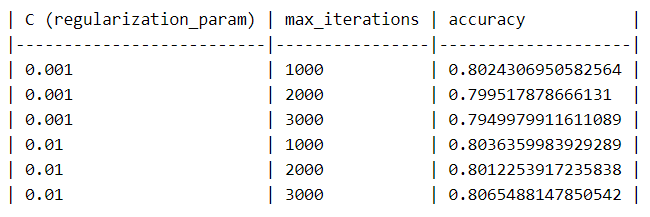

Increasing `c` will lead to minimizing the margin while increasing the training error. This prevents the model from overfitting on the train data and helps increase the test accuracy. 

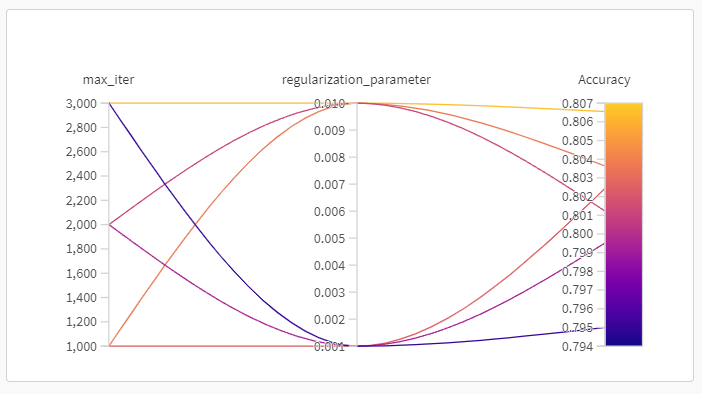

